In [1]:
%%capture
!pip install einops
!pip install pytorch-lightning
!pip install bottleneck
!pip install torchtext

In [20]:
import gc
import torch
import einops
import pandas as pd
import numpy as np
import xarray as xr
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets

from torch import nn
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [3]:
def prepare_data(stock_id, stock_ind, set, time_ids, coarsen, norm, out):
    df_book = pd.read_parquet(f'{data_dir}/book_{set}.parquet/stock_id={stock_id}')
    df_min_second = df_book.groupby('time_id').agg(min_second=('seconds_in_bucket', 'min'))
    df_book = df_book.merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    df_trade = pd.read_parquet(f'{data_dir}/trade_{set}.parquet/stock_id={stock_id}') \
        .merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    df = pd.merge(df_book, df_trade, on=['time_id', 'seconds_in_bucket'], how='outer')
    df['stock_id'] = stock_id
    df = df.set_index(['stock_id', 'time_id', 'seconds_in_bucket'])
    df = df.to_xarray().astype('float32')
    df = df.reindex({'time_id': time_ids, 'seconds_in_bucket': np.arange(n_seconds)})
    for name in ['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2',
         'bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']:
        df[name] = df[name].ffill('seconds_in_bucket')
    df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
    df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
    df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
    df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')
    df['current_vol'] = (df.log_return1 ** 2).sum('seconds_in_bucket') ** 0.5
    df['current_vol_2nd_half'] = (df.log_return1[..., 300:] ** 2).sum('seconds_in_bucket') ** 0.5
    if coarsen > 1:
        mean_features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price']
        sum_features = ['size', 'order_count']

        df = xr.merge((df[mean_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').mean(),
                       df[sum_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').sum(),
                       df[['current_vol', 'current_vol_2nd_half']]))
        df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
        df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
        df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
        df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')

    df['spread1'] = df.ask_price1 - df.bid_price1
    df['spread2'] = df.ask_price2 - df.ask_price1
    df['spread3'] = df.bid_price1 - df.bid_price2
    df['total_volume'] = df.ask_size1 + df.ask_size2 + df.bid_size1 + df.bid_size2
    df['volume_imbalance1'] = df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2
    df['volume_imbalance2'] = (df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2) / df.total_volume
    for name in ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2', 'size', 'order_count', 'total_volume']:
        df[name] = np.log1p(df[name])
#         df[name] = df[name].rank('seconds_in_bucket')
    df['volume_imbalance1'] = np.sign(df['volume_imbalance1']) * np.log1p(abs(df['volume_imbalance1']))

    df = df.fillna({'ask_price1': 1, 'ask_price2': 1, 'bid_price1': 1, 'bid_price2': 1,  'ask_size1': 0, 'ask_size2': 0,
               'bid_size1': 0, 'bid_size2': 0, 'price': 1, 'size': 0, 'order_count': 0, 'wap1': 1, 'wap2': 1,
               'log_return1': 0, 'log_return2': 0, 'spread1': 0, 'spread2': 0, 'spread3': 0, 'total_volume': 0,
               'volume_imbalance1': 0, 'volume_imbalance2': 0, 'current_vol': 0, 'current_vol_2nd_half': 0})
    features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price', 'size', 'order_count', 'wap1', 'wap2',
               'log_return1', 'log_return2', 'spread1', 'spread2', 'spread3', 'total_volume',
               'volume_imbalance1', 'volume_imbalance2']
    extra = ['current_vol', 'current_vol_2nd_half']

    if norm is not None:
        mean = norm['mean'].sel(stock_id=stock_id)
        std = norm['std'].sel(stock_id=stock_id)
    else:
        mean = df.mean(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])
        std = df.std(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])

    df.update((df - mean) / std)
    df = df.astype('float32')

    out[:, stock_ind] = einops.rearrange(df[features].to_array().values, 'f () t sec -> t sec f')
    return df[extra], {'mean': mean, 'std': std}

class OptiverDataset(Dataset):
    def __init__(self, features_data, extra_data, mode, time_ids):
        self.features_data = features_data
        self.extra_data = extra_data
        self.time_ids = time_ids
        self.mode = mode

    def __len__(self):
        if self.mode == 'single-stock':
            return len(self.time_ids) * n_stocks
        elif self.mode == 'multi-stock':
            return len(self.time_ids)

    def __getitem__(self, i):
        if self.mode == 'single-stock':
            time_id = self.time_ids[i // n_stocks]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            stock_ind = i % n_stocks
            stock_id = self.extra_data.indexes['stock_id'][stock_ind]
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind, stock_ind],  # (1,)
                'current_vol': self.extra_data['current_vol'].values[time_ind, stock_ind],  # (1,)
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind, stock_ind],  # (1,)
                'time_id': time_id,
                'stock_id': stock_id,
                'stock_ind': stock_ind
            }
        elif self.mode == 'multi-stock':
            time_id = self.time_ids[i]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind],  # (112,)
                'current_vol': self.extra_data['current_vol'].values[time_ind],  # (112,)
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind],  # (112,)
                'time_id': time_id,
            }

In [4]:
data_dir = 'optiver-realized-volatility-prediction'
n_features = 21
n_stocks = 112
n_seconds = 600
# if coarsen > 1, data will be aggregated per this number of seconds,
# use this to reduce memory usage, though during competition I trained on full data,
# so I'm not sure how it can affect model performance
coarsen = 3

In [5]:
df_train = pd.read_csv(f'{data_dir}/train.csv')

train_extra = xr.open_dataset('optiver-realized-volatility-prediction/train_extra.nc')
train_data = np.load('optiver-realized-volatility-prediction/train_data.npy')
# train_data = np.memmap(f'{data_dir}/train.npy', 'float16', 'w+',
#                        shape=(df_train.time_id.nunique(), n_stocks, n_seconds // coarsen, n_features))

# res = Parallel(n_jobs=4, verbose=51)(
#     delayed(prepare_data)(stock_id, stock_ind, 'train', df_train.time_id.unique(), coarsen, None, train_data)
#     for stock_ind, stock_id in enumerate(df_train.stock_id.unique())
# )

# train_extra = xr.concat([x[0] for x in res], 'stock_id')
# train_extra['target'] = df_train.set_index(['time_id', 'stock_id']).to_xarray()['target'].astype('float32')
# train_extra = train_extra.transpose('time_id', 'stock_id')
# # train_norm = {
# #     'mean': xr.concat([x[1]['mean'] for x in res], 'stock_id'),
# #     'std': xr.concat([x[1]['std'] for x in res], 'stock_id')
# # }

# # if you data fits in memory, you can load it entirely from disk, otherwise
# # training in single-stock mode could be very slow, though it can be OK for multi-stock mode
# train_data = np.array(train_data)

In [ ]:
train_data = np.memmap(f'{data_dir}/train.npy', 'float16', 'w+',
                       shape=(df_train.time_id.nunique(), n_stocks, n_seconds // coarsen, n_features))

res = Parallel(n_jobs=4, verbose=51)(
    delayed(prepare_data)(stock_id, stock_ind, 'train', df_train.time_id.unique(), coarsen, None, train_data)
    for stock_ind, stock_id in enumerate(df_train.stock_id.unique())
)

train_extra = xr.concat([x[0] for x in res], 'stock_id')
train_extra['target'] = df_train.set_index(['time_id', 'stock_id']).to_xarray()['target'].astype('float32')
train_extra = train_extra.transpose('time_id', 'stock_id')

train_data = np.array(train_data)

train_time_ids = df_train[df_train["time_id"] < 22385]["time_id"].unique().tolist()
val_time_ids = df_train[(df_train["time_id"] >= 22385) & (df_train["time_id"] < 29239)]["time_id"].unique().tolist()
test_time_ids = df_train[df_train["time_id"] >= 29239]["time_id"].unique().tolist()

train_ds = OptiverDataset(train_data, train_extra, 'multi-stock', train_time_ids)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)

val_ds = OptiverDataset(train_data, train_extra, 'multi-stock', val_time_ids)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

test_ds = OptiverDataset(train_data, train_extra, 'multi-stock', test_time_ids)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

In [6]:
train_time_ids = df_train[df_train["time_id"] < 22385]["time_id"].unique().tolist()
val_time_ids = df_train[(df_train["time_id"] >= 22385) & (df_train["time_id"] < 29239)]["time_id"].unique().tolist()
test_time_ids = df_train[df_train["time_id"] >= 29239]["time_id"].unique().tolist()
len(train_time_ids), len(val_time_ids), len(test_time_ids)

(2681, 765, 384)

In [7]:
time_ids = train_extra.indexes['time_id'].values

# multi-stock training (fast)
train_ds = OptiverDataset(train_data, train_extra, 'multi-stock', train_time_ids)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)

val_ds = OptiverDataset(train_data, train_extra, 'multi-stock', val_time_ids)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

test_ds = OptiverDataset(train_data, train_extra, 'multi-stock', test_time_ids)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

# single-stock training (slow)
# train_ds = OptiverDataset(train_data, train_extra, 'single-stock', time_ids[train_time_ids])
# train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)
# val_ds = OptiverDataset(train_data, train_extra, 'single-stock', time_ids[val_time_ids])
# val_dl = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

In [8]:
len(train_ds)

2681

In [9]:
from pytorch_lightning.callbacks import Callback
import logging
logger = logging.getLogger(__name__)

class LoggingCallback(Callback):
    def __init__(self, log_every, every_epoch=1):
        super().__init__()
        self.log_every = log_every
        self.every_epoch = every_epoch
        self.count = 0
        self.stats = []

    def on_epoch_start(self, trainer, pl_module):
        self.count = 0

    def on_validation_batch_end(self, trainer, pl_module):
        if self.log_every != -1:
            logger.info(
                f"Epoch: {trainer.current_epoch}\t\t"
                + "\t".join(
                    [
                        f"{k}:{v}" if isinstance(v, str) else f"{k}:{v:.4f}"
                        for k, v in trainer.progress_bar_metrics.items()
                    ]
                )
            )
        self.stats.append({k: v for k, v in trainer.progress_bar_metrics.items()})

In [23]:
class TimeAttention(nn.Module):
    def __init__(self, steps):
        super().__init__()
        self.steps = steps
        self.weights = nn.Parameter(torch.zeros(steps))

    def forward(self, x):
        # x: (b, st, t, f)
        attn = F.softmax(self.weights, 0)
        x = torch.einsum('b s t f, t -> b s f', x, attn)
        return x

# You can experiment with other ideas for stock attention: maybe it could be
# something like MultiHeadAttention module with keys and queries that depends on current input,
# maybe it could be a linear combination of all stocks (full connected layer),
# maybe you can try sparse softmax
class StockAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((n_stocks, n_stocks)))
        self.bias = nn.Parameter(torch.zeros(n_stocks))
        self.fc_combine = nn.Linear(dim * 2, dim)

    def forward(self, x):
        # x: (b, st, t, f)
        attn = F.softmax(self.weight + self.bias[None, :], dim=-1) # (st, st)
        y = torch.einsum('b i ..., j i -> b j ...', x, attn)
        x = torch.cat((x, y), -1)
        x = self.fc_combine(x)
        return x

class OptiverModel(pl.LightningModule):
    def __init__(self, mode='multi-stock', dim=32, conv1_kernel=3, rnn_layers=2, rnn_dropout=0.3,
                 n_features=21, aux_loss_weight=1.0):
        super().__init__()
        self.save_hyperparameters()
        self.stock_emb = nn.Embedding(n_stocks, dim)
        self.stock_emb.weight.data.normal_(0, 0.2)
        self.conv1 = nn.Conv1d(n_features, dim, conv1_kernel, conv1_kernel)
        self.conv2 = nn.Conv1d(dim, dim, 1, 1)
        self.norm1 = nn.LayerNorm([n_stocks, dim])
        self.norm2 = nn.LayerNorm([n_stocks, dim])
        self.rnn = nn.GRU(dim, dim, rnn_layers, batch_first=True, dropout=rnn_dropout)
        self.timesteps_attn = TimeAttention(600 // conv1_kernel // coarsen)
        self.timesteps_attn2 = TimeAttention(300 // conv1_kernel // coarsen)
        self.stock_attn = StockAttention(dim)
        self.fc_out1 = nn.Linear(dim, 1)
        self.fc_out2 = nn.Linear(dim, 1)
        self.history = pd.DataFrame()

        self.vol_predictions = []
        self.vol_target = []

        self.stats = []

    def forward(self, x, stock_ind=None):
        # x: (b, st, t, f)
        # print(x.shape)
        x = einops.rearrange(x, 'b st t f -> (b st) f t')
        x = self.conv1(x)
        x = einops.rearrange(x, '(b st) f t -> b t st f', st=n_stocks)
        x = F.gelu(x)
        x = self.norm1(x)
        x = einops.rearrange(x, 'b t st f -> (b st) f t')
        x = self.conv2(x)
        x = einops.rearrange(x, '(b st) f t -> b t st f', st=n_stocks)
        x = F.gelu(x)
        x = self.norm2(x)
        x = einops.rearrange(x, 'b t st f -> b st t f')
        x = self.stock_attn(x)
        x = x + self.stock_emb.weight[None, :, None, :]
        if self.hparams.mode == 'single-stock':
            x = x[torch.arange(len(x)), stock_ind][:, None]
        x = einops.rearrange(x, 'b st t f -> (b st) t f')
        x = self.rnn(x)[0]
        x = einops.rearrange(x, '(b st) t f -> b st t f', st=n_stocks if self.hparams.mode == 'multi-stock' else 1)
        x1 = self.timesteps_attn(x)
        x2 = self.timesteps_attn2(x[:, :, :self.timesteps_attn2.steps, :])
        x1 = self.fc_out1(x1)
        x2 = self.fc_out2(x2)
        x1 = x1 * 0.63393 - 5.762331
        x2 = x2 * 0.67473418 - 6.098946
        x1 = torch.exp(x1)
        x2 = torch.exp(x2)
        if self.hparams.mode == 'single-stock':
            return {
                'vol': x1[:, 0, 0], # (b,)
                'vol2': x2[:, 0, 0] # (b,)
            }
        else:
            return {
                'vol': x1[..., 0], # (b, st)
                'vol2': x2[..., 0] # (b, st)
            }

    def training_step(self, batch, batch_ind):
        res = self.common_step(batch, 'train')
        loss = res['loss']
        target = res['target']
        pred = res["vol"]

        # self.vol_target.append(target)
        # self.vol_predictions.append(pred)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_ind):
        res = self.common_step(batch, 'valid')
        loss = res['loss']
        target = res['target']
        pred = res["vol"]

        self.vol_target.append(target)
        self.vol_predictions.append(pred)

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def common_step(self, batch, stage):
        out = self(batch['data'], batch['stock_ind'] if self.hparams.mode == 'single-stock' else None)
        mask1 = ~torch.isnan(batch['target'])
        target1 = torch.where(mask1, batch['target'], torch.tensor(1.0, device=self.device))
        mask2 = batch['current_vol_2nd_half'] > 0
        target2 = torch.where(mask2, batch['current_vol_2nd_half'], torch.tensor(1.0, device=self.device))
        vol_loss = (((out['vol'] - target1) / target1) ** 2)[mask1].mean() ** 0.5
        vol2_loss = (((out['vol2'] - target2) / target2) ** 2)[mask2].mean() ** 0.5
        loss = vol_loss + self.hparams.aux_loss_weight * vol2_loss
        # self.log(f'{stage}/loss', loss.item(), on_step=False, on_epoch=True)
        # self.log(f'{stage}/vol_loss', vol_loss.item(), on_step=False, on_epoch=True)
        # self.log(f'{stage}/vol2_loss', vol2_loss.item(), on_step=False, on_epoch=True)
        return {
            'loss': loss,
            'target': batch['target'],
            'vol': out['vol'].detach(),
            'time_id': batch['time_id']
        }

    def common_epoch_end(self, outs, stage):
        print("outs:", outs)  # Add this line to print the contents of outs

        target = torch.cat([x['target'] for x in outs])
        vol = torch.cat([x['vol'] for x in outs])
        time_ids = torch.cat([x['time_id'] for x in outs])
        mask = ~torch.isnan(target)
        target = torch.where(mask, target, torch.tensor(1.0, device=self.device))
        rmspe = (((vol - target) / target) ** 2)[mask].mean() ** 0.5
        self.log(f'{stage}/rmspe', rmspe, prog_bar=True, on_step=False, on_epoch=True)
        self.history.loc[self.trainer.current_epoch, f'{stage}/rmspe'] = rmspe.item()

    # def on_train_epoch_end(self):

    #     all_preds = torch.cat(self.vol_predictions, dim=0)
    #     all_targets = torch.cat(self.vol_target, dim=0)
    #     mask = ~torch.isnan(all_targets)
    #     rmspe = (((all_preds - all_targets) / all_targets) ** 2)[mask].mean() ** 0.5
    #     self.log('rmspe_train', rmspe, prog_bar=True, logger=True)

    #     self.vol_predictions.clear()
    #     self.vol_target.clear()
    #     print("clear train")

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.vol_predictions, dim=0)
        all_targets = torch.cat(self.vol_target, dim=0)
        mask = ~torch.isnan(all_targets)
        rmspe = (((all_preds - all_targets) / all_targets) ** 2)[mask].mean() ** 0.5
        self.log('rmspe_val', rmspe, prog_bar=True, logger=True)

        self.vol_predictions.clear()
        self.vol_target.clear()

        self.stats.append({k: v for k, v in self.trainer.progress_bar_metrics.items()})

        # print("clear val")


    # def on_fit_start(self):
    #     self.history_widget = widgets.Output()
    #     display(self.history_widget)

    def configure_optimizers(self):
        opt = AdamW(self.parameters(), lr=1e-3)
#         opt = Adam(self.parameters(), lr=0.0005) # single-stock
        sched = {
            'scheduler': ExponentialLR(opt, 0.93),
#             'scheduler': ExponentialLR(opt, 0.9), #  single-stock
            'interval': 'epoch'
        }
        return [opt], [sched]

In [24]:
model = OptiverModel(mode='multi-stock', dim=32, conv1_kernel=1, aux_loss_weight=1) # multi-stock
# model = OptiverModel(mode='single-stock', conv1_kernel=1, aux_loss_weight=0) # single-stock
# model.summarize(max_depth=1)

In [25]:
trainer = pl.Trainer(accelerator='auto',
                     precision=16,
                     max_epochs=50,
                     enable_progress_bar=True) # multi-stock
# trainer = pl.Trainer(gpus=1, precision=16, limit_train_batches=2500, max_epochs=25) # single-stock

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model, train_dl, val_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type           | Params | Mode 
------------------------------------------------------------
0  | stock_emb       | Embedding      | 3.6 K  | train
1  | conv1           | Conv1d         | 704    | train
2  | conv2           | Conv1d         | 1.1 K  | train
3  | norm1           | LayerNorm      | 7.2 K  | train
4  | norm2           | LayerNorm      | 7.2 K  | train
5  | rnn             | GRU            | 12.7 K | train
6  | timesteps_attn  | TimeAttention  | 200    | train
7  | timesteps_attn2 | TimeAttention  | 100    | train
8  | stock_attn      | StockAttention | 14.7 K | train
9  | fc_out1         | Linear         | 33     | train
10 | fc_out2         | Linear         | 33     | train
------------------------------------------------------------
47.5 K    Trainable params
0         Non-trainable params
47.5 K    Total params
0.190 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


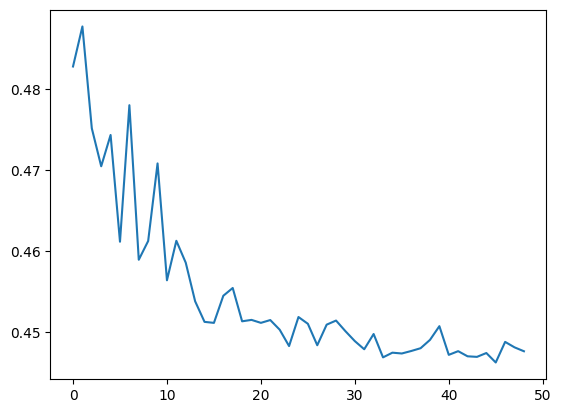

In [33]:
plt.plot([x["val_loss_epoch"] for x in model.stats[2:]])
plt.show()

## Test set metrics

In [16]:
batch['data'].dtype

torch.float16

In [ ]:
X_tensor.type(torch.float64)

In [35]:
pred_list = []
target_list = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dl):
        out = model(batch['data'].type(torch.float32))

        pred = out['vol'].detach()
        target = batch['target']

        pred_list.append(pred)
        target_list.append(target)

  0%|          | 0/12 [00:00<?, ?it/s]

In [36]:
all_preds = torch.cat(pred_list, dim=0)
all_targets = torch.cat(target_list, dim=0)
mask = ~torch.isnan(all_targets)
rmspe = (((all_preds - all_targets) / all_targets) ** 2)[mask].mean() ** 0.5
print(rmspe)

tensor(0.2065)
